<h3> Including agents of extreme saving characteristics </h3>
 <h5>i.e. no savings($\lambda$ = 0) and saving whole money ($\lambda$ =1)

In [6]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from mesa.space import NetworkGrid
import networkx as nx
import os
#from tqdm.autonotebook import tqdm

In [2]:
class MoneyAgent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.m = self.model.T
        self.lamda = round(random.random(),1)

    def move(self):
        possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False)
                          if self.model.grid.is_cell_empty(node)]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

    def give_money(self):

        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            if(other.unique_id != self.unique_id): 
                if(other.lamda == self.lamda):
                    xi = self.m
                    xj = other.m
                    #print(xi, xj, xi+xj)
                    delta_m = (1-self.lamda)*(xi - epsilon*(xi + xj))
                    xi_new = xi - delta_m
                    xj_new = xj + delta_m
                    other.m = xj_new
                    self.m = xi_new
                    self.model.trade+=1
    def step(self):
        if self.m > 0:
            self.give_money()
        self.move()

In [3]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,T,N,num_nodes): #N- number of agents

        self.N = N
        self.num_nodes = num_nodes if num_nodes >= self.N else self.N
        self.G = nx.nx.barabasi_albert_graph(n=self.num_nodes, m = 20) #n-number of nodes, m-number of edges to attach 
                                                                                   # from a new node to existing nodes

        self.T = T
        self.trade = 0
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {'trade': 'trade'},agent_reporters={"mi":'m','lamda':'lamda' })
                                                                                      # 'mi' : lambda _: _.m ?
        #nx.draw(self.G)
        list_of_random_nodes = self.random.sample(self.G.nodes(), self.N)

        # Create agents
        for i in range(self.N):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random node
            self.grid.place_agent(a, list_of_random_nodes[i])

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.step()
            self.trade = 0


<h3>6000 steps

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


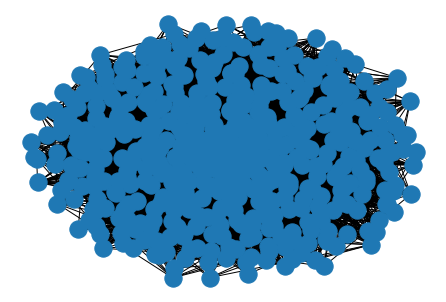

In [4]:
N = 500
num_nodes = 200
T = 100
steps = 6000
model = BoltzmannWealthModelNetwork(T,N,num_nodes)
model.run_model(steps)

model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)

In [7]:
#saving files
file = "Version1\Run_{}Steps".format(steps)
os.makedirs(file)
model_df.loc[1:].to_csv(file+"\Model_Run{}Steps.csv".format(steps))
agent_df['mt'] = agent_df.mi/T
agent_df.to_csv(file + "\Agent_Run{}.csv".format(steps))

In [8]:
data = pd.read_csv(file + "\Agent_Run{}.csv".format(steps))
data.head()

,Step,AgentID,mi,lamda,mt
0,0,0,100.0,0.5,1.0
1,0,1,100.0,0.3,1.0
2,0,2,100.0,0.7,1.0
3,0,3,100.0,0.9,1.0
4,0,4,100.0,1.0,1.0


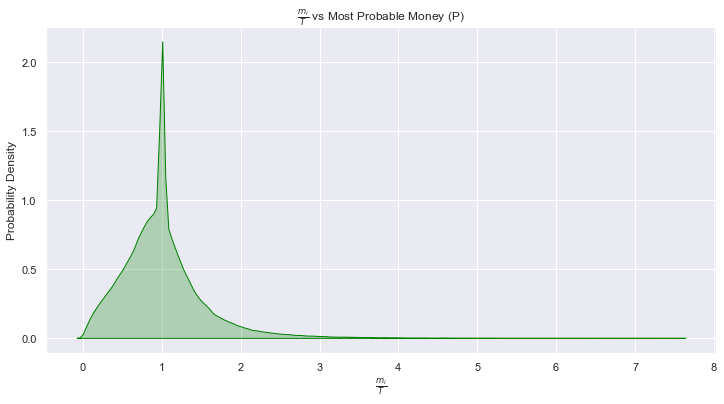

In [11]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
sns.kdeplot(data.mt, fill = True, color = 'green')
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability Density")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money (P)") 
plt.savefig(file + "\kdeplot_homophily");

<h3> Time Series data of each agent

In [31]:
agent = random.randint(0,499)
time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data.loc[data['AgentID']==agent, 'mi'].reset_index(drop = True)).to_numpy()
lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]

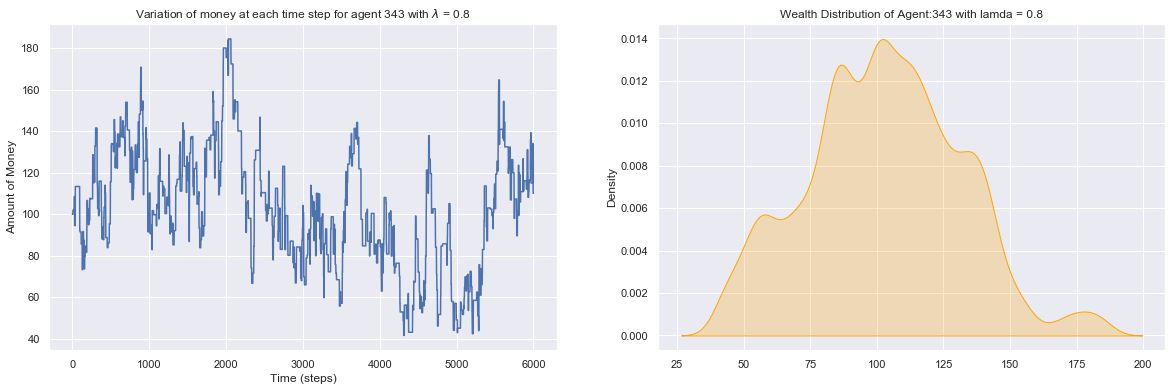

In [32]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,6)})
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)
ax1.plot(time,money)
ax1.set_title("Variation of money at each time step for agent {} with $\lambda$ = {}".format(agent,lamda))
ax1.set_xlabel("Time (steps)")
ax1.set_ylabel("Amount of Money")
sns.kdeplot(money, fill =True, color = 'orange', ax = ax2)
ax2.set_title("Wealth Distribution of Agent:{} with lamda = {}".format(agent, lamda))
plt.savefig(file +"\WealthDist_agent{}".format(agent))

In [37]:
trade = pd.read_csv(file + "\Model_Run{}Steps.csv".format(steps))
trade = trade.rename(columns ={'Unnamed: 0':"Step"}) 
trade.tail()

,Step,trade
5995,5996,56
5996,5997,41
5997,5998,45
5998,5999,41
5999,6000,39


Text(0.5, 1.0, 'Total number of trades at a time step')

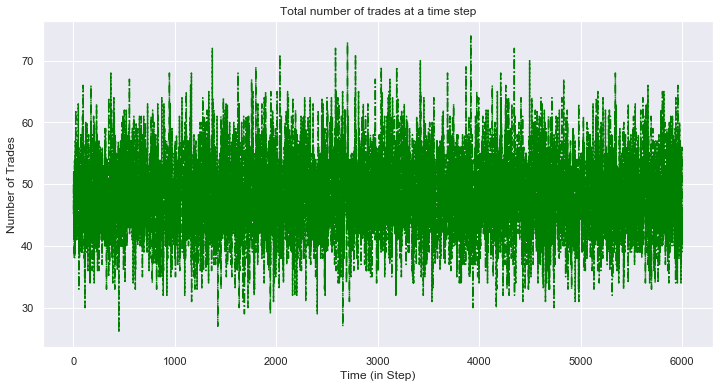

In [44]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
plt.plot(trade.Step, trade.trade, '-.', color = 'green')
plt.xlabel("Time (in Step)")
plt.ylabel("Number of Trades")
plt.title("Total number of trades at a time step")

<h4> 10000 steps

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


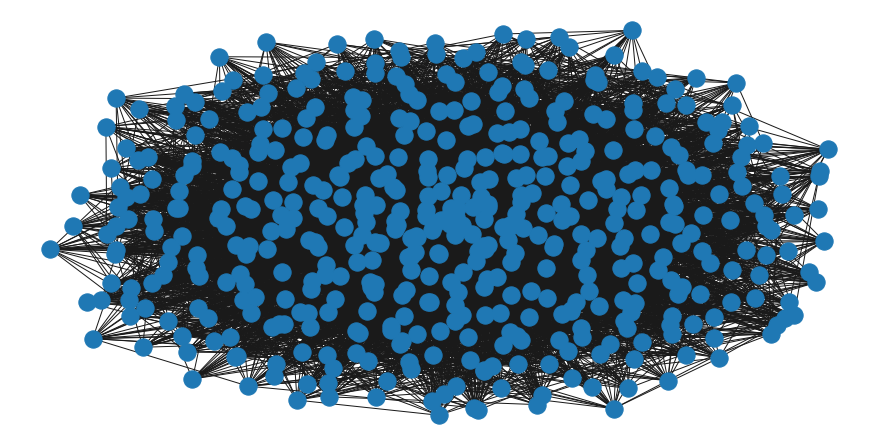

In [45]:
N = 500
num_nodes = 200
T = 100
steps1 = 10000
model = BoltzmannWealthModelNetwork(T,N,num_nodes)
model.run_model(steps1)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)

In [46]:
file1 = "Version1\Run_{}Steps".format(steps1)
os.makedirs(file1)
model_df.loc[1:].to_csv(file1+"\Model_Run{}Steps.csv".format(steps1))
agent_df['mt'] = agent_df.mi/T
agent_df.to_csv(file1 + "\Agent_Run{}.csv".format(steps1))

<h4> Time Series data for each agent

In [47]:
data1 = pd.read_csv(file1 + "\Agent_Run{}.csv".format(steps1))
data1.head()

,Step,AgentID,mi,lamda,mt
0,0,0,100.0,0.2,1.0
1,0,1,100.0,0.5,1.0
2,0,2,100.0,0.4,1.0
3,0,3,100.0,0.4,1.0
4,0,4,100.0,0.8,1.0


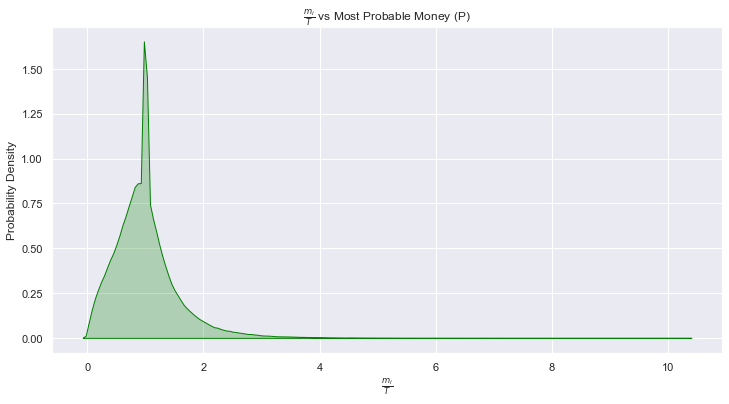

In [48]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
sns.kdeplot(data1.mt, fill = True, color = 'green')
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability Density")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money (P)") 
plt.savefig(file1 + "\kdeplot_homophily");

In [65]:
agent = random.randint(0,499)
time = (data1.loc[data1['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data1.loc[data1['AgentID']==agent, 'mi'].reset_index(drop = True)).to_numpy()
lamda = data1.loc[data1['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]

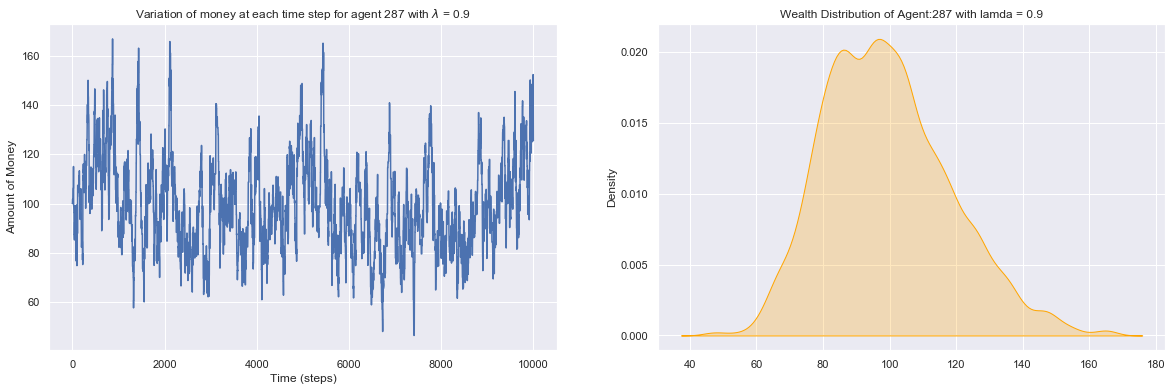

In [66]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,6)})
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)
ax1.plot(time,money)
ax1.set_title("Variation of money at each time step for agent {} with $\lambda$ = {}".format(agent,lamda))
ax1.set_xlabel("Time (steps)")
ax1.set_ylabel("Amount of Money")
sns.kdeplot(money, fill =True, color = 'orange', ax = ax2)
ax2.set_title("Wealth Distribution of Agent:{} with lamda = {}".format(agent, lamda))
plt.savefig(file1 +"\WealthDist_agent{}".format(agent))

In [51]:
trade1 = pd.read_csv(file1 + "\Model_Run{}Steps.csv".format(steps1))
trade1 = trade1.rename(columns ={'Unnamed: 0':"Step"}) 
trade1.tail()

,Step,trade
9995,9996,56
9996,9997,51
9997,9998,49
9998,9999,50
9999,10000,53


Text(0.5, 1.0, 'Total number of trades at a time step')

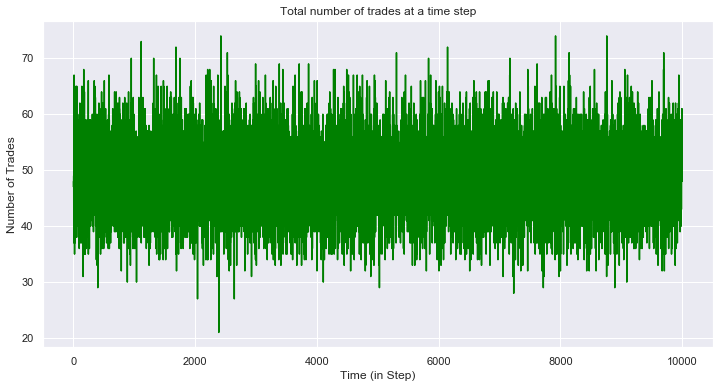

In [52]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
plt.plot(trade1.Step, trade1.trade, '-', color = 'green')
plt.xlabel("Time (in Step)")
plt.ylabel("Number of Trades")
plt.title("Total number of trades at a time step")